**Feature Extraction and Classifiction model on COVID Dataset**



*   Feature vector extraction through Gabor filter

*   Feature vector extraction through Resnet model using transfer learning
*   Implement SVM classification


*   Model Performance Evaluation



In [ ]:
# Import Libraries
import os
from distutils.file_util import copy_file
import glob
import cv2
import numpy as np

from sklearn import preprocessing
#from keras.utils import to_categorical

from tensorflow.keras.applications import resnet50
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix, roc_curve

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# I load dataset from google drive
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Data Preprocessing**

In [ ]:
covidXrayPath='/content/drive/MyDrive/covid_dataset1/COVID' # path to COVID dataset in drive
normalXrayPath='/content/drive/MyDrive/covid_dataset1/Normal' # path to Normal dataset in drive

# Lists for datasets paths
listCovidPaths = []
listNormalPaths = []

# Get covid x-rays files paths
for root, directories, files in os.walk(covidXrayPath):
    for name in files:
        listCovidPaths.append(os.path.join(root, name))

# Get normal x-rays files paths
for root, directories, files in os.walk(normalXrayPath):
    for name in files:
        listNormalPaths.append(os.path.join(root, name))

print("Total Covid Images:",len(listCovidPaths))
print("Total Normal Images:",len(listNormalPaths))

Total Covid Images: 1500
Total Normal Images: 1500


In [ ]:
for i in range(5):
  print(listNormalPaths[i])

/content/drive/MyDrive/covid_dataset1/Normal/Normal-1397.png
/content/drive/MyDrive/covid_dataset1/Normal/Normal-1440.png
/content/drive/MyDrive/covid_dataset1/Normal/Normal-1434.png
/content/drive/MyDrive/covid_dataset1/Normal/Normal-1438.png
/content/drive/MyDrive/covid_dataset1/Normal/Normal-1442.png


In [ ]:
# main directories/folders to store train & test images of covid and normal separately
!mkdir /content/drive/MyDrive/covid_dataset1/Data/
!mkdir /content/drive/MyDrive/covid_dataset1/Data/Train/ # train directory
!mkdir /content/drive/MyDrive/covid_dataset1/Data/Test/ # test directory

!mkdir /content/drive/MyDrive/covid_dataset1/Data/Train/Covid/ # Covid train directory
!mkdir /content/drive/MyDrive/covid_dataset1/Data/Train/Normal/ # Normal train directory

!mkdir /content/drive/MyDrive/covid_dataset1/Data/Test/Covid/ # Covid test directory
!mkdir /content/drive/MyDrive/covid_dataset1/Data/Test/Normal/ # Normal test directory

In [ ]:
# Path to directory of covid images
pathCovidTrain = '/content/drive/MyDrive/covid_dataset1/Data/Train/Covid/'
pathCovidTest = '/content/drive/MyDrive/covid_dataset1/Data/Test/Covid/'

# Path to directory of normal images
pathNormalTrain = '/content/drive/MyDrive/covid_dataset1/Data/Train/Normal/'
pathNormalTest = '/content/drive/MyDrive/covid_dataset1/Data/Test/Normal/'

pathtrain = '/content/drive/MyDrive/covid_dataset1/Data/Train'
pathtest = '/content/drive/MyDrive/covid_dataset1/Data/Test'

In [ ]:
#Moving images to new specified directory
# Move covid/normal images files to new folders (train/test)
# 85% of total data in train set and 15% in test set
for i in range(1500):
    if i < 1275:
        copy_file(listCovidPaths[i], pathCovidTrain)
        copy_file(listNormalPaths[i], pathNormalTrain)
    else  :
        copy_file(listCovidPaths[i], pathCovidTest)
        copy_file(listNormalPaths[i], pathNormalTest)


**Gabor Filter and feature extraction**

In [ ]:
# This is the function of Gabor filters.
# First create gabor filter bank, then apply filter bank on input images
# and then extract feature vector return the list of gabor features
def gabor_filter(img):
  # use gabor filter from cv2
	# cv2.getGaborKernel(ksize, sigma, theta, lambda, gamma, psi, ktype)
	# ksize - size of gabor filter (n, n)
	# sigma - standard deviation of the gaussian function
	# theta - orientation of the normal to the parallel stripes
	# lambda - wavelength of the sunusoidal factor
	# gamma - spatial aspect ratio
	# psi - phase offset
	# ktype - type and range of values that each pixel in the gabor kernel can hold
	g_kernels = []
	ksize=12
	for theta in range(2): # 0,np.pi/6,np.pi/4,np.pi/3,np.pi/2,np.pi
		theta = theta/4. *np.pi
		for sigma in (1,3):
			for lamda in np.arange(0,np.pi,np.pi/4):
				for gamma in (0.05,0.5):
					g_kernal = cv2.getGaborKernel((ksize,ksize), sigma, theta, lamda, gamma, 0, ktype=cv2.CV_32F)
					g_kernels.append(g_kernal)

	img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
	filtered_imgs = []
	for g_kernel in g_kernels:
		filtered_img = cv2.filter2D(img, cv2.CV_8UC3, g_kernel)
		filtered_imgs.append(filtered_img)
		#cv2.imshow('image', g_kernel)
		#cv2.imshow('filtered image', filtered_img)
		h, w = g_kernel.shape[:2]
		g_kernel = cv2.resize(g_kernel, (3*w, 3*h), interpolation=cv2.INTER_CUBIC)
		#cv2.imshow('image', g_kernel)
	gabor_features = []
	for image in filtered_imgs:
		gabor_features.append((resultant_amplitude(image)))
	return gabor_features

# This function takes filtered_image as parameter and return amplitude of the filtered image
def resultant_amplitude(filtered_img):
	length = len(filtered_img) * len(filtered_img[0])
	amplitude = 0
	for item in filtered_img:
		for elem in item:
			amplitude+=abs(elem)
	return amplitude/length


In [ ]:
# Apply gabor filter funtion and extract feature vectors from images
# First on train images dataset
with open('gb_features_train.txt','w') as f:
  for directory_path in glob.glob(pathtrain+"/*"): # get into train directory
    for image_path in glob.glob(os.path.join(directory_path, "*.png")): # get into directories of covid/normal in train and get path of every image
      image = cv2.imread(image_path) # read every image
      features = [] # all features to be appended

      # apply gabor_filter and get gabor_features from image
      gabor_features = gabor_filter(image)
      features.extend(gabor_features)
      #print (len(features))
      f.write(','.join(str("{0:.5f}".format(i)) for i in features))
      f.write("\n")

In [ ]:
# Apply gabor filter funtion and extract feature vectors from images
# Now on test images dataset
with open('gb_features_test.txt','w') as f:
  for directory_path in glob.glob(pathtest+"/*"): # get into test directory
    for image_path in glob.glob(os.path.join(directory_path, "*.png")): # get into directories of covid/normal in test and get path of every image
      image = cv2.imread(image_path) # read every image
      features = [] # all features to be appended

      # apply gabor_filter and get gabor_features from image
      gabor_features = gabor_filter(image)
      features.extend(gabor_features)
      #print (len(features))
      f.write(','.join(str("{0:.5f}".format(i)) for i in features))
      f.write("\n")

In [ ]:
# Now get extracted features vector from our saved text files into list
with open('gb_features_train.txt') as file:
    gb_features_train = file.readlines()
gb_features_train = [x.strip() for x in gb_features_train]

with open('gb_features_test.txt') as file:
    gb_features_test = file.readlines()
gb_features_test = [x.strip() for x in gb_features_test]

X_train_gb =[]
for item in gb_features_train:
    mylist = item.split(',')
    X_train_gb.append(list(map(float, mylist)))

X_test_gb =[]
for item in gb_features_test:
    mylist = item.split(',')
    X_test_gb.append(list(map(float, mylist)))

# Convert into numpy array to feed in Machine learning model later
X_train_gb = np.array(X_train_gb)
X_test_gb = np.array(X_test_gb)

In [ ]:
print("Train features vector:",X_train_gb.shape)
print("Test features vector:",X_test_gb.shape)

Train features vector: (2550, 32)
Test features vector: (450, 32)


**Data Processing**

In [ ]:
# DATA PREPRCESSING
SIZE = 224  #images size
# Get training data and labels into respective lists
train_images = []
train_labels = []

for directory_path in glob.glob(pathtrain+"/*"):
    label = directory_path.split("\\")[-1]
    #print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*")):
        #print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        train_labels.append(label)
#Convert lists to numpy arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [ ]:
# Get test data and labels into respective lists
test_images = []
test_labels = []

for directory_path in glob.glob(pathtest+"/*"):
    label = directory_path.split("\\")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        test_images.append(img)
        test_labels.append(label)
#Convert lists to numpy arrays
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [ ]:
#Encode labels from text to integers.
label_encode = preprocessing.LabelEncoder()
label_encode.fit(test_labels)
test_labels_encoded = label_encode.transform(test_labels)
label_encode.fit(train_labels)
train_labels_encoded = label_encode.transform(train_labels)

In [ ]:
# assigning train/test to meaningful convention
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

In [ ]:
from collections import Counter
Counter(y_train)

Counter({0: 1275, 1: 1275})

In [ ]:
# Normalize pixel values to between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

**RESNET Transfer learning and feature extraction**

In [ ]:
# Load RESNET model from keras applications
RESNET_model = resnet50.ResNet50(
    include_top = False,
    weights = 'imagenet',
    input_shape = (SIZE,SIZE,3),
    classifier_activation = 'sigmoid'
)

# make trainable parameters as False for 40 layers
# Freez first 40 layers and use last 10 layers in training on our own data
for i in range(40):
  RESNET_model.layers[i].trainable = False

#RESNET_model.summary()

# Now extract features from RESNET network for SVM
RESNET_features_train = RESNET_model.predict(x_train)
X_train_RESNET = RESNET_features_train.reshape(RESNET_features_train.shape[0], -1)

RESNET_features_test = RESNET_model.predict(x_test)
X_test_RESNET = RESNET_features_test.reshape(RESNET_features_test.shape[0], -1)

**SVC on resnet transfer learning features vetor**

In [ ]:
# #Support Vector Machine Classifier
SVM_model_res = SVC(probability=True)

# # Train classifier model on training data
SVM_model_res.fit(X_train_RESNET, y_train) #For sklearn no one hot encoding

SVC(probability=True)

In [ ]:
#Now predict using the trained SVM model
prediction_SVM_res = SVM_model_res.predict(X_test_RESNET)

# #Inverse label encoding le transform to get original label back.
prediction_SVM_res_labels = label_encode.inverse_transform(prediction_SVM_res)

In [ ]:
def evaluation_metrics(y_true, y_pred):
    print("Model Performance Evaluation:\n")
    accuracy = round(accuracy_score(y_true, y_pred) * 100, 2)
    precision = round(precision_score(y_true, y_pred,average='weighted') * 100, 2)
    f1Score = round(f1_score(y_true, y_pred, average='weighted') * 100, 2)
    target_names=['Abnormal','Normal']
    cm=confusion_matrix(y_true, y_pred)
    tn = cm[0][0]
    fn = cm[1][0]
    tp = cm[1][1]
    fp = cm[0][1]
    specificity = tn / (tn+fp)
    sensitivity = tp / (tp+fn)
    ppv= tp / (tp+fp)
    npr= tn / (tn+fn)

    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("f1Score : {}".format(f1Score))
    print("\nconfusion_matrix")
    print(cm)
    print("\nTrue Positive  : {}".format(tp))
    print("True Negative  : {}".format(tn))
    print("Flase Positive  : {}".format(fp))
    print("False Negative  : {}".format(fn))

    print("\nSpecificity  : {}".format(specificity))
    print("Sensitivity  : {}".format(sensitivity))
    print("Positive predictive value (PPV): {}".format(ppv))
    print("Negative predictive value (NPV)  : {}".format(npr))

    return accuracy, precision, f1Score, cm

In [ ]:
evaluation_metrics(y_test, prediction_SVM_res)

Model Performance Evaluation:

Accuracy  : 99.56
Precision : 99.56
f1Score : 99.56

confusion_matrix
[[224   1]
 [  1 224]]

True Positive  : 224
True Negative  : 224
Flase Positive  : 1
False Negative  : 1

Specificity  : 0.9955555555555555
Sensitivity  : 0.9955555555555555
Positive predictive value (PPV): 0.9955555555555555
Negative predictive value (NPV)  : 0.9955555555555555


(99.56, 99.56, 99.56, array([[224,   1],
        [  1, 224]]))

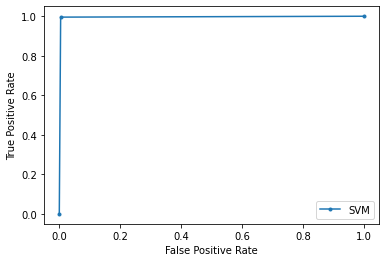

In [ ]:
# Plot the ROC curve for the model
fpr, tpr, _ = roc_curve(y_test, prediction_SVM_res)
plt.plot(fpr, tpr, marker='.', label='SVM')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

**SVC on Gabor features vector**

In [ ]:
# #Support Vector Machine Classifier
SVM_model_gb = SVC(probability=True)

# # Train classifier model on training data
SVM_model_gb.fit(X_train_gb, y_train) #For sklearn no one hot encoding

SVC(probability=True)

In [ ]:
#Now predict using the trained SVM model
prediction_SVM_gb = SVM_model_gb.predict(X_test_gb)

# #Inverse label encoding le transform to get original label back.
prediction_SVM_gb_labels = label_encode.inverse_transform(prediction_SVM_gb)

In [ ]:
evaluation_metrics(y_test, prediction_SVM_gb)

Model Performance Evaluation:

Accuracy  : 76.22
Precision : 76.87
f1Score : 76.08

confusion_matrix
[[154  71]
 [ 36 189]]

True Positive  : 189
True Negative  : 154
Flase Positive  : 71
False Negative  : 36

Specificity  : 0.6844444444444444
Sensitivity  : 0.84
Positive predictive value (PPV): 0.7269230769230769
Negative predictive value (NPV)  : 0.8105263157894737


(76.22, 76.87, 76.08, array([[154,  71],
        [ 36, 189]]))

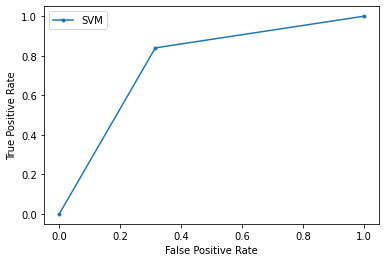

In [ ]:
# Plot the ROC curve for the model
fpr, tpr, _ = roc_curve(y_test, prediction_SVM_gb)
plt.plot(fpr, tpr, marker='.', label='SVM')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

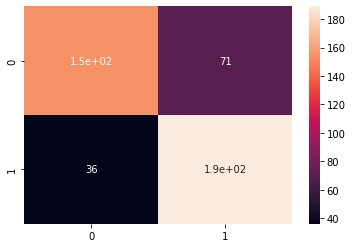

In [ ]:
# Confusion metric heatmap
import seaborn as sns
cm = confusion_matrix(y_test, prediction_SVM_gb)
#print(cm)
sns.heatmap(cm, annot=True)

**SVC on Combine Features vector**

In [ ]:
# Combine both extracted features vectors from Gabor filter and from RESNET
X_train_for_SVM = []
X_test_for_SVM = []
for i in range(len(x_train)):
  Xt = np.concatenate((X_train_RESNET[i], X_train_gb[i]))
  X_train_for_SVM.append(Xt)
for i in range(len(x_test)):
  Xt_ = np.concatenate((X_test_RESNET[i], X_test_gb[i]))
  X_test_for_SVM.append(Xt_)

# Convert lists into numpy arrays
X_train_for_SVM = np.array(X_train_for_SVM)
X_test_for_SVM = np.array(X_test_for_SVM)


In [ ]:
# #Support Vector Machine Classifier
SVM_model = SVC(probability=True)

# # Train classifier model on training data
SVM_model.fit(X_train_for_SVM, y_train) #For sklearn no one hot encoding

SVC(probability=True)

In [ ]:
# save model for later use
import pickle
filename = 'finalized_model.sav'
pickle.dump(SVM_model, open(filename, 'wb'))

In [ ]:
#Now predict using the trained SVM model
prediction_SVM = SVM_model.predict(X_test_for_SVM)

# #Inverse label encoding le transform to get original label back.
prediction_SVM_labels = label_encode.inverse_transform(prediction_SVM)

In [ ]:
evaluation_metrics(y_test, prediction_SVM)

Model Performance Evaluation:

Accuracy  : 99.78
Precision : 99.78
f1Score : 99.78

confusion_matrix
[[225   0]
 [  1 224]]

True Positive  : 224
True Negative  : 225
Flase Positive  : 0
False Negative  : 1

Specificity  : 1.0
Sensitivity  : 0.9955555555555555
Positive predictive value (PPV): 1.0
Negative predictive value (NPV)  : 0.995575221238938


(99.78, 99.78, 99.78, array([[225,   0],
        [  1, 224]]))

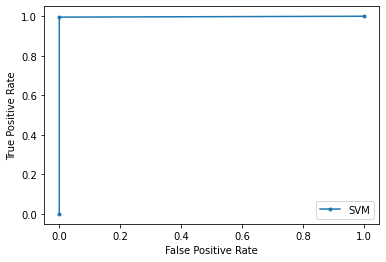

In [ ]:
# Plot the ROC curve for the model
fpr, tpr, _ = roc_curve(y_test, prediction_SVM)
plt.plot(fpr, tpr, marker='.', label='SVM')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

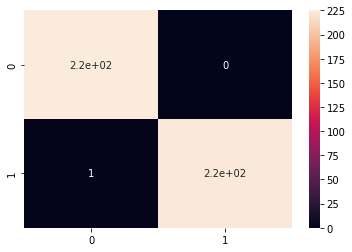

In [ ]:
# Confusion metric heatmap
cm = confusion_matrix(y_test, prediction_SVM)
#print(cm)
sns.heatmap(cm, annot=True)

**Transfer Learning Model Training and Tunning**

In [ ]:
from tensorflow.keras.layers import Flatten, Dense, Input
from tensorflow.keras.models import Sequential
# Load RESNET model from keras applications
RESNET_model = resnet50.ResNet50(
    include_top = False,
    weights = 'imagenet',
    input_shape = (SIZE,SIZE,3),
    classifier_activation = 'sigmoid'
)
# Train all
for i in range(50):
  RESNET_model.layers[i].trainable = True

model = Sequential()
model.add(RESNET_model)
model.add(Flatten())
model.add(Dense(2, activation = 'softmax'))
model.compile(optimizer='rmsprop',loss = 'binary_crossentropy', metrics = ['accuracy'])
#print(new_model.summary())

from tensorflow.keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

#Train the NEW Model
history = model.fit(x_train, y_train_one_hot, epochs=5, batch_size=32, validation_split = 0.2)

Accuracy =  0.9222222222222223
[[218   7]
 [ 28 197]]


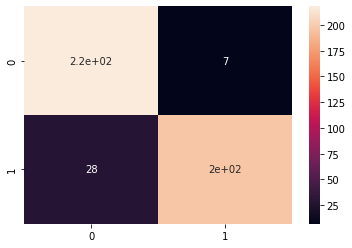

In [ ]:
prediction_model = model.predict(x_test)
prediction_model = np.argmax(prediction_model, axis=-1)
prediction_model_inv_en = label_encode.inverse_transform(prediction_model)
import seaborn as sns
#Print overall accuracy
print ("Accuracy = ", accuracy_score(y_test, prediction_model))

#Confusion Matrix - verify accuracy of each class
cm = confusion_matrix(y_test, prediction_model)
print(cm)
sns.heatmap(cm, annot=True)
#Check results on a few select images

**Use Self Trained Model as transfer learning and classification**

In [ ]:
import tensorflow as tf
path_to_model = "/content/drive/MyDrive/resnet18_scratch (1).h5"
trained_model = tf.keras.models.load_model(path_to_model)
trained_model.summary()

Model: "ResNet34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 115, 115, 64  9472        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                           

In [ ]:
# Freez first 5 layers and use last layers in training on our own data
for i in range(5):
  trained_model.layers[i].trainable = False

In [ ]:
# We will get from the Flatten layer of trained model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
flatten_feature_extractor = trained_model.layers[-3].output
add_layer = Dense(128, activation = "relu", kernel_initializer = 'he_uniform')(flatten_feature_extractor)
prediction_layer = Dense(2, activation = 'sigmoid')(add_layer)

# Make a new model combining both the flatten layer of trained model and x
new_model = Model(inputs=trained_model.input, outputs=prediction_layer)
new_model.compile(optimizer='rmsprop',loss = 'binary_crossentropy', metrics = ['accuracy'])
#print(new_model.summary())

from tensorflow.keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

#Train the NEW Model
history = new_model.fit(x_train, y_train_one_hot, epochs=5, validation_split = 0.2)


Epoch 1/5
64/64 [==============================] - 634s 9s/step - loss: 1.9587 - accuracy: 0.8078 - val_loss: 0.5733 - val_accuracy: 0.6765
Epoch 2/5
64/64 [==============================] - 591s 9s/step - loss: 0.5031 - accuracy: 0.8426 - val_loss: 0.8791 - val_accuracy: 0.8255
Epoch 3/5
64/64 [==============================] - 588s 9s/step - loss: 0.5350 - accuracy: 0.8564 - val_loss: 0.2024 - val_accuracy: 0.8941
Epoch 4/5
64/64 [==============================] - 586s 9s/step - loss: 0.3418 - accuracy: 0.8833 - val_loss: 0.5313 - val_accuracy: 0.7412
Epoch 5/5
64/64 [==============================] - 588s 9s/step - loss: 0.3242 - accuracy: 0.8877 - val_loss: 0.1074 - val_accuracy: 0.9353


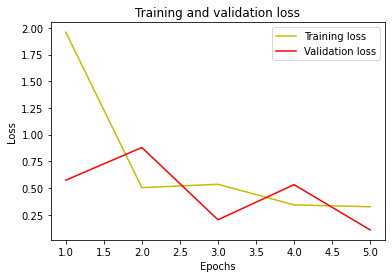

In [ ]:
#plot the training and validation loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show() # so loss is decreasing

In [ ]:
prediction_NN = new_model.predict(x_test)
prediction_NN = np.argmax(prediction_NN, axis=-1)
prediction_NN_inv_en = label_encode.inverse_transform(prediction_NN)

In [ ]:
evaluation_metrics(y_test, prediction_NN)

Model Performance Evaluation:

Accuracy  : 92.22
Precision : 92.59
f1Score : 92.21

confusion_matrix
[[218   7]
 [ 28 197]]

True Positive  : 197
True Negative  : 218
Flase Positive  : 7
False Negative  : 28

Specificity  : 0.9688888888888889
Sensitivity  : 0.8755555555555555
Positive predictive value (PPV): 0.9656862745098039
Negative predictive value (NPV)  : 0.8861788617886179


(92.22, 92.59, 92.21, array([[218,   7],
        [ 28, 197]]))